<a href="https://colab.research.google.com/github/gmenendez0/7506R-2C2023-GRUPO07/blob/main/Submission_Kaggle_Rafa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [351]:
!pip install 'dtreeviz'
import pandas as pd
import numpy as np

#Visualización
import matplotlib.pyplot as plt
import seaborn as sns
import dtreeviz

#modelos y métricas
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score#, precision_recall_curve, roc_curve,
from sklearn.metrics import confusion_matrix, classification_report

#preprocesamiento
from sklearn.preprocessing import MinMaxScaler

#configuración warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [352]:
# Cargamos el ds test
dsHotelTest = pd.read_csv("./hotels_test.csv")
dsHotelTestCopy = dsHotelTest.copy()

In [353]:
dsHotelTestCopy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26535 entries, 0 to 26534
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           26535 non-null  object 
 1   lead_time                       26535 non-null  int64  
 2   arrival_date_year               26535 non-null  int64  
 3   arrival_date_month              26535 non-null  object 
 4   arrival_date_week_number        26535 non-null  int64  
 5   arrival_date_day_of_month       26535 non-null  int64  
 6   stays_in_weekend_nights         26535 non-null  int64  
 7   stays_in_week_nights            26535 non-null  int64  
 8   adults                          26535 non-null  int64  
 9   children                        26535 non-null  float64
 10  babies                          26535 non-null  int64  
 11  meal                            26535 non-null  object 
 12  country                         

#Aplicamos tratamiento de valores faltantes con el mismo criterio del CHP1 y encodeamos columnas

In [354]:
columnas_con_na = dsHotelTestCopy.columns[dsHotelTestCopy.isna().any()].tolist()
print("Columnas con valores faltantes:")
for columna in columnas_con_na:
    print(f"{columna}: {dsHotelTestCopy[columna].isna().sum()} valores faltantes")

Columnas con valores faltantes:
country: 95 valores faltantes
agent: 3363 valores faltantes
company: 25218 valores faltantes


In [355]:
#AGENT
dsHotelTestCopy['agent'].fillna(-1, inplace=True)
#COUNTRY
dsHotelTestCopy['country'].fillna(dsHotelTestCopy.country.mode()[0], inplace=True)
#COMPANY
dsHotelTestCopy.drop('company', axis='columns', inplace = True)

In [356]:
#Eliminamos columnas consideradas inusables
variables_inusables = ['id','arrival_date_week_number']
dsHotelTestCopy.drop(variables_inusables, axis='columns', inplace = True)


In [357]:
#chequeamos nulos
dsHotelTestCopy.isna().sum()

hotel                             0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces       0
total_of_special_requests         0
reservation_status_date     

In [358]:
#variables_categoricas_ds_test
variables_categoricas_ds_test = dsHotelTestCopy.select_dtypes(include=['object']).columns.tolist()


In [359]:
#VEMOS CANTIDAD DE VALORES UNICOS POR COLUMNA
dsHotelTestCopy[variables_categoricas_ds_test].nunique()

hotel                        2
arrival_date_month          12
meal                         5
country                    135
market_segment               7
distribution_channel         4
reserved_room_type          10
assigned_room_type          11
deposit_type                 3
customer_type                4
reservation_status_date    886
dtype: int64

In [360]:
conteo_valores = dsHotelTest['country'].value_counts().reset_index()
conteo_valores.columns = ['Valor', 'Conteo']
print(conteo_valores)

    Valor  Conteo
0     PRT   12029
1     GBR    2387
2     FRA    2118
3     ESP    1757
4     DEU    1405
..    ...     ...
130   MLT       1
131   ATF       1
132   TZA       1
133   PAK       1
134   NIC       1

[135 rows x 2 columns]


In [361]:
#ENCODEAMOS COUNTRY EN TOP 10 Y OTROS
dsHotelTestCopy['country_top_5_and_others'] = dsHotelTestCopy['country'].where(
dsHotelTestCopy['country'].isin(dsHotelTestCopy['country'].value_counts().nlargest(6).index), 'Others')
dsHotelTestCopy.drop('country',axis=1, inplace=True)

#convertimos arrival_date_month a int64
meses_a_numeros = {
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July': 7,
    'August': 8,
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12
}
dsHotelTestCopy['arrival_date_month'] = dsHotelTestCopy['arrival_date_month'].map(meses_a_numeros)

#eliminamos reservation_status_date @error en el ds test
dsHotelTestCopy.drop('reservation_status_date', axis='columns', inplace = True)

#agregamos high_season_moth
mediana_meses = dsHotelTestCopy['arrival_date_month'].value_counts().median()
dsHotelTestCopy['high_season_month'] = dsHotelTestCopy['arrival_date_month'].apply(lambda x: 1 if dsHotelTestCopy['arrival_date_month'].value_counts()[x] > mediana_meses else 0)


#actualizamos variables_categoricas_ds_test
variables_categoricas_ds_test = dsHotelTestCopy.select_dtypes(include=['object']).columns.tolist()


In [362]:
#aplico one-hot (get_dummies)
dsHotelTestCopy = pd.get_dummies(dsHotelTestCopy, columns=variables_categoricas_ds_test, drop_first=True)
dsHotelTestCopy.head()

,lead_time,arrival_date_year,arrival_date_month,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,...,deposit_type_Refundable,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,country_top_5_and_others_ESP,country_top_5_and_others_FRA,country_top_5_and_others_GBR,country_top_5_and_others_ITA,country_top_5_and_others_Others,country_top_5_and_others_PRT
0,277,2016,11,7,1,2,2,0.0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,286,2016,5,11,0,4,2,0.0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,0,2016,8,23,0,1,3,0.0,0,0,...,0,0,1,0,0,1,0,0,0,0
3,196,2016,10,29,2,5,2,2.0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,232,2016,11,26,2,1,2,0.0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [363]:
#importamos ds entrenamiento del CHP1
dsHotelCHP1=pd.read_csv('./dsHotelCHP1.csv')
ds_trabajo = dsHotelCHP1.copy()

In [364]:
#variables_categoricas_ds_test
variables_categoricas_ds_entrenamiento = ds_trabajo.select_dtypes(include=['object']).columns.tolist()
#VEMOS CANTIDAD DE VALORES UNICOS POR COLUMNA
ds_trabajo[variables_categoricas_ds_entrenamiento].nunique()

hotel                       2
meal                        5
country                   149
market_segment              7
distribution_channel        4
reserved_room_type          9
assigned_room_type         11
deposit_type                3
customer_type               4
id                      60414
dtype: int64

In [365]:
#ELIMINO ID (FALTO HACERLO EN CHP1)
variables_inusables = ['id']
ds_trabajo.drop(variables_inusables, axis='columns', inplace = True)


#ENCODEAMOS COUNTRY EN TOP 10 Y OTROS (harcelo en el chp1?)
ds_trabajo['country_top_5_and_others'] = ds_trabajo['country'].where(
ds_trabajo['country'].isin(ds_trabajo['country'].value_counts().nlargest(6).index), 'Others')
ds_trabajo.drop('country',axis=1, inplace=True)

#ACTUALIZO VARIABLES_CATEGORICAS_DS_ENTRENAMIENTO
variables_categoricas_ds_entrenamiento = ds_trabajo.select_dtypes(include=['object']).columns.tolist()

#LAZY, aplico one-hot al ds_test (get_dummies)
ds_trabajo = pd.get_dummies(ds_trabajo, columns=variables_categoricas_ds_test, drop_first=True)
ds_trabajo.head()

,lead_time,arrival_date_year,arrival_date_month,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,...,deposit_type_Refundable,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,country_top_5_and_others_ESP,country_top_5_and_others_FRA,country_top_5_and_others_GBR,country_top_5_and_others_ITA,country_top_5_and_others_Others,country_top_5_and_others_PRT
0,49,2016,9,5,1,2,1,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1,4,2015,10,31,0,1,2,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,25,2016,10,13,0,1,2,2,0,0,...,0,0,1,0,0,0,0,0,1,0
3,26,2016,12,12,2,5,2,0,0,0,...,0,0,1,0,0,0,0,0,0,1
4,104,2017,3,19,2,5,2,0,0,0,...,0,0,0,1,0,1,0,0,0,0


In [366]:
#me reboto cuando hice el predict contra el ds_test ("debugeo")
test = set(dsHotelTestCopy.columns)
entrenamiento = set(ds_trabajo.columns)

missing = list(sorted(test - entrenamiento))
added = list(sorted(entrenamiento - test))

print('Faltan en el entrenamiento:', missing)
print('Sobran en el entrenamiento:', added)

Faltan en el entrenamiento: ['assigned_room_type_P', 'reserved_room_type_P']
Sobran en el entrenamiento: ['assigned_room_type_L', 'is_canceled']


#tratamiento de valores sobrantes en el ds_test

In [367]:
#veo su frecuencia antes de hacer el one-hot con get dummies (uso el ds_test original), se podria graficar
conteo_valores = dsHotelTest['assigned_room_type'].value_counts().reset_index()
conteo_valores.columns = ['Valor', 'Conteo']
print(conteo_valores)

   Valor  Conteo
0      A   17218
1      D    5316
2      E    1576
3      F     764
4      G     517
5      C     445
6      B     439
7      H     135
8      I      66
9      K      54
10     P       5


In [368]:
# veo muy pocos casos de assigned_room_type_P, decido movelor a la siguiente menor frecuencia, K

dsHotelTestCopy['assigned_room_type_K'] = dsHotelTestCopy['assigned_room_type_K'] + dsHotelTestCopy['assigned_room_type_P']
# Elimino 'assigned_room_type_p'
dsHotelTestCopy.drop(columns=['assigned_room_type_P'], inplace=True)

In [369]:
conteo_valores = dsHotelTest['reserved_room_type'].value_counts().reset_index()
conteo_valores.columns = ['Valor', 'Conteo']
print(conteo_valores)

  Valor  Conteo
0     A   19366
1     D    4176
2     E    1352
3     F     630
4     G     442
5     B     241
6     C     202
7     H     118
8     P       5
9     L       3


In [370]:
# veo muy pocos casos de reserver_room_type_P, decido mover a la menor frecuencia existente, L
dsHotelTestCopy['reserved_room_type_L'] = dsHotelTestCopy['reserved_room_type_L'] + dsHotelTestCopy['reserved_room_type_P']
# Elimino 'reserved_room_type_P'
dsHotelTestCopy.drop(columns=['reserved_room_type_P'], inplace=True)

#tratamiento valores sobrantes en el ds_entrenamiento

In [371]:
#veo su frecuencia antes de hacer el one-hot con get dummies (uso el ds entrenamiento original), se podria graficar
conteo_valores = dsHotelCHP1['assigned_room_type'].value_counts().reset_index()
conteo_valores.columns = ['Valor', 'Conteo']
print(conteo_valores)

   Valor  Conteo
0      A   39425
1      D   11975
2      E    3681
3      F    1737
4      G    1131
5      C    1081
6      B     924
7      H     329
8      K      72
9      I      58
10     L       1


In [372]:
# lo muevo a la siguiente menor frecuencia, I
ds_trabajo['assigned_room_type_I'] = ds_trabajo['assigned_room_type_I'] + ds_trabajo['assigned_room_type_L']
# Elimino 'assigned_room_type_L'
ds_trabajo.drop(columns=['assigned_room_type_L'], inplace=True)

#Entrenamiento y prediccion (sin optimizar)


In [375]:
target = 'is_canceled'
ds_trabajo_x = ds_trabajo.drop(target, axis='columns', inplace=False)

features = ds_trabajo_x.columns.tolist()
#Creo un dataset con la variable target
ds_trabajo_y = ds_trabajo['is_canceled'].copy()

#Genero los conjuntos de train y de test
x_train, x_test, y_train, y_test = train_test_split(ds_trabajo_x,
                                                    ds_trabajo_y,
                                                    test_size=0.2, # 80/20
                                                    random_state=7,
                                                    stratify=ds_trabajo_y.values) #GRUPO 7 C:

In [376]:
#Creamos un clasificador con hiperparámetros
tree_model = tree.DecisionTreeClassifier(criterion="gini",
                                         max_depth = 20,
                                         min_samples_leaf=10)
#Entrenamos el modelo
model = tree_model.fit(X = x_train, y = y_train)

#Realizamos una predicción sobre el x_test
y_pred = model.predict(x_test)
#Valores Predichos
y_pred

array([0, 0, 0, ..., 0, 1, 1])

Text(0.5, 1.0, 'matriz de confusion del modelo sin optimizar')

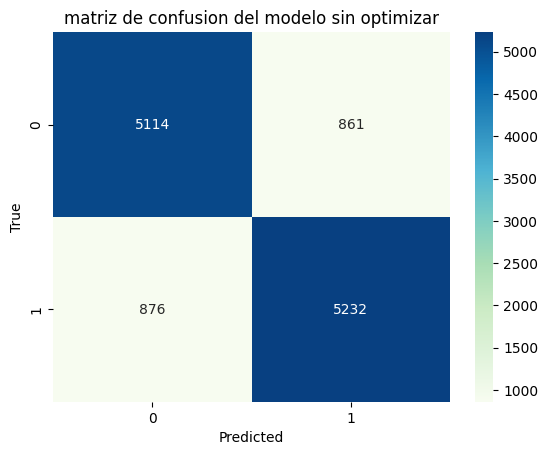

In [377]:
#MATRIZ CONFUSION
tabla=confusion_matrix(y_test, y_pred)
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('matriz de confusion del modelo sin optimizar')

In [378]:
#Calculo las métricas en el conjunto de evaluación
accuracy=accuracy_score(y_test,y_pred)
recall=recall_score(y_test,y_pred)
f1=f1_score(y_test,y_pred,)
precision=precision_score(y_test,y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.8562443101878673
Recall: 0.8565815324165029
Precision: 0.8586903003446578
f1 score: 0.8576346201131054


In [379]:
#exporto el modelo
import joblib
joblib.dump(model, 'modelo_sin_hiperparametro.joblib')

['modelo_sin_hiperparametro.joblib']

#Prediccion del modelo sin optimizar contra ds_test

In [380]:
#cargamos modelo
model = joblib.load('./modelo_sin_hiperparametro.joblib')

y_pred_sin_optimizar = model.predict(dsHotelTestCopy)
#Valores Predichos
y_pred_sin_optimizar


array([1, 0, 0, ..., 1, 1, 0])

In [381]:
#exporto la prediccion
df_submission = pd.DataFrame({'id': dsHotelTest['id'], 'is_canceled': y_pred_sin_optimizar})
df_submission.head()

,id,is_canceled
0,e6d0d58a-ab96-44d3-b28f-85df1cc15f1e,1
1,aba9aac2-4495-4645-a60e-90328713c999,0
2,b345b5dc-c804-4d77-a39f-1f4e65d1f1ad,0
3,ce1b400e-afa1-4946-bdff-004b859eb61c,1
4,c4fbec0d-8e2e-4db2-9d4f-a6ccb9f51214,1


In [382]:
df_submission.to_csv('sin_hiperparametro.csv', index=False)

In [383]:
#grafico arbol sin optimizar, (seteo max_depth en 5, para que no tarde )
plt.figure(figsize=(100,100))

tree_plot_completo=tree.plot_tree(model,
                                 feature_names=ds_trabajo_x.columns.to_list(),
                                 filled=True,
                                 rounded=True,
                                 class_names=['not_cancelled','cancelled'],
                                 max_depth = 5)
plt.show(tree_plot_completo)

#Optimizamos con Random Search Cross Validation

In [384]:
from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, f1_score

combinaciones = 15
folds = 15
params_grid = {'criterion':['gini','entropy'],
                'min_samples_leaf':list(range(1,6)),
                'min_samples_split': list(range(2,11)),
               #'ccp_alpha':np.linspace(0,0.05,combinaciones), #con poda da peores resultados
                'max_depth':list(range(10,31))}

kfoldcv = StratifiedKFold(n_splits=folds)

base_tree = DecisionTreeClassifier()

scorer_fn = make_scorer(f1_score)

randomcv = RandomizedSearchCV(estimator=base_tree,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=combinaciones,
                              random_state = 7)

randomcv.fit(x_train,y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=15, random_state=None, shuffle=False),
                   estimator=DecisionTreeClassifier(), n_iter=15,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20, 21,
                                                      22, 23, 24, 25, 26, 27,
                                                      28, 29, 30],
                                        'min_samples_leaf': [1, 2, 3, 4, 5],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10]},
                   random_state=7, scoring=make_scorer(f1_score))

In [385]:
print("Mostramos los mejores resultados: ")
print(randomcv.best_params_)
print()
print("Mostramos el mejor resultado obtenido de busqueda aleatoria: ")
print("f1_score = ",randomcv.best_score_)

Mostramos los mejores resultados: 
{'min_samples_split': 5, 'min_samples_leaf': 5, 'max_depth': 15, 'criterion': 'entropy'}

Mostramos el mejor resultado obtenido de busqueda aleatoria: 
f1_score =  0.8534669389067525


In [386]:
# Valores estadisticos de f1_score
randomcv.cv_results_['mean_test_score']

array([0.85296565, 0.85333677, 0.84568356, 0.84626088, 0.84269232,
       0.85143997, 0.83759569, 0.84423706, 0.85185873, 0.85346694,
       0.85103091, 0.84514784, 0.8430039 , 0.85062364, 0.85190802])

In [387]:
#Creo el árbol con los mejores hiperparámetros
from sklearn.tree import export_text

arbol=DecisionTreeClassifier().set_params(**randomcv.best_params_)

#Entreno el arbol en todo el set
arbol.fit(x_train,y_train)

#print reglas de decision
reglas = export_text(arbol, feature_names=list(features))
print(reglas)

|--- deposit_type_Non Refund <= 0.50
|   |--- required_car_parking_spaces <= 0.50
|   |   |--- lead_time <= 8.50
|   |   |   |--- country_top_5_and_others_PRT <= 0.50
|   |   |   |   |--- agent <= 8.50
|   |   |   |   |   |--- previous_cancellations <= 0.50
|   |   |   |   |   |   |--- agent <= 2.00
|   |   |   |   |   |   |   |--- market_segment_Online TA <= 0.50
|   |   |   |   |   |   |   |   |--- lead_time <= 2.50
|   |   |   |   |   |   |   |   |   |--- adults <= 1.50
|   |   |   |   |   |   |   |   |   |   |--- assigned_room_type_D <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 5
|   |   |   |   |   |   |   |   |   |   |--- assigned_room_type_D >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |--- adults >  1.50
|   |   |   |   |   |   |   |   |   |   |--- agent <= 0.00
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 4
|   |   |   |   |   |   |   |   |   |   |--- ag

Grafico del arbol optimizado

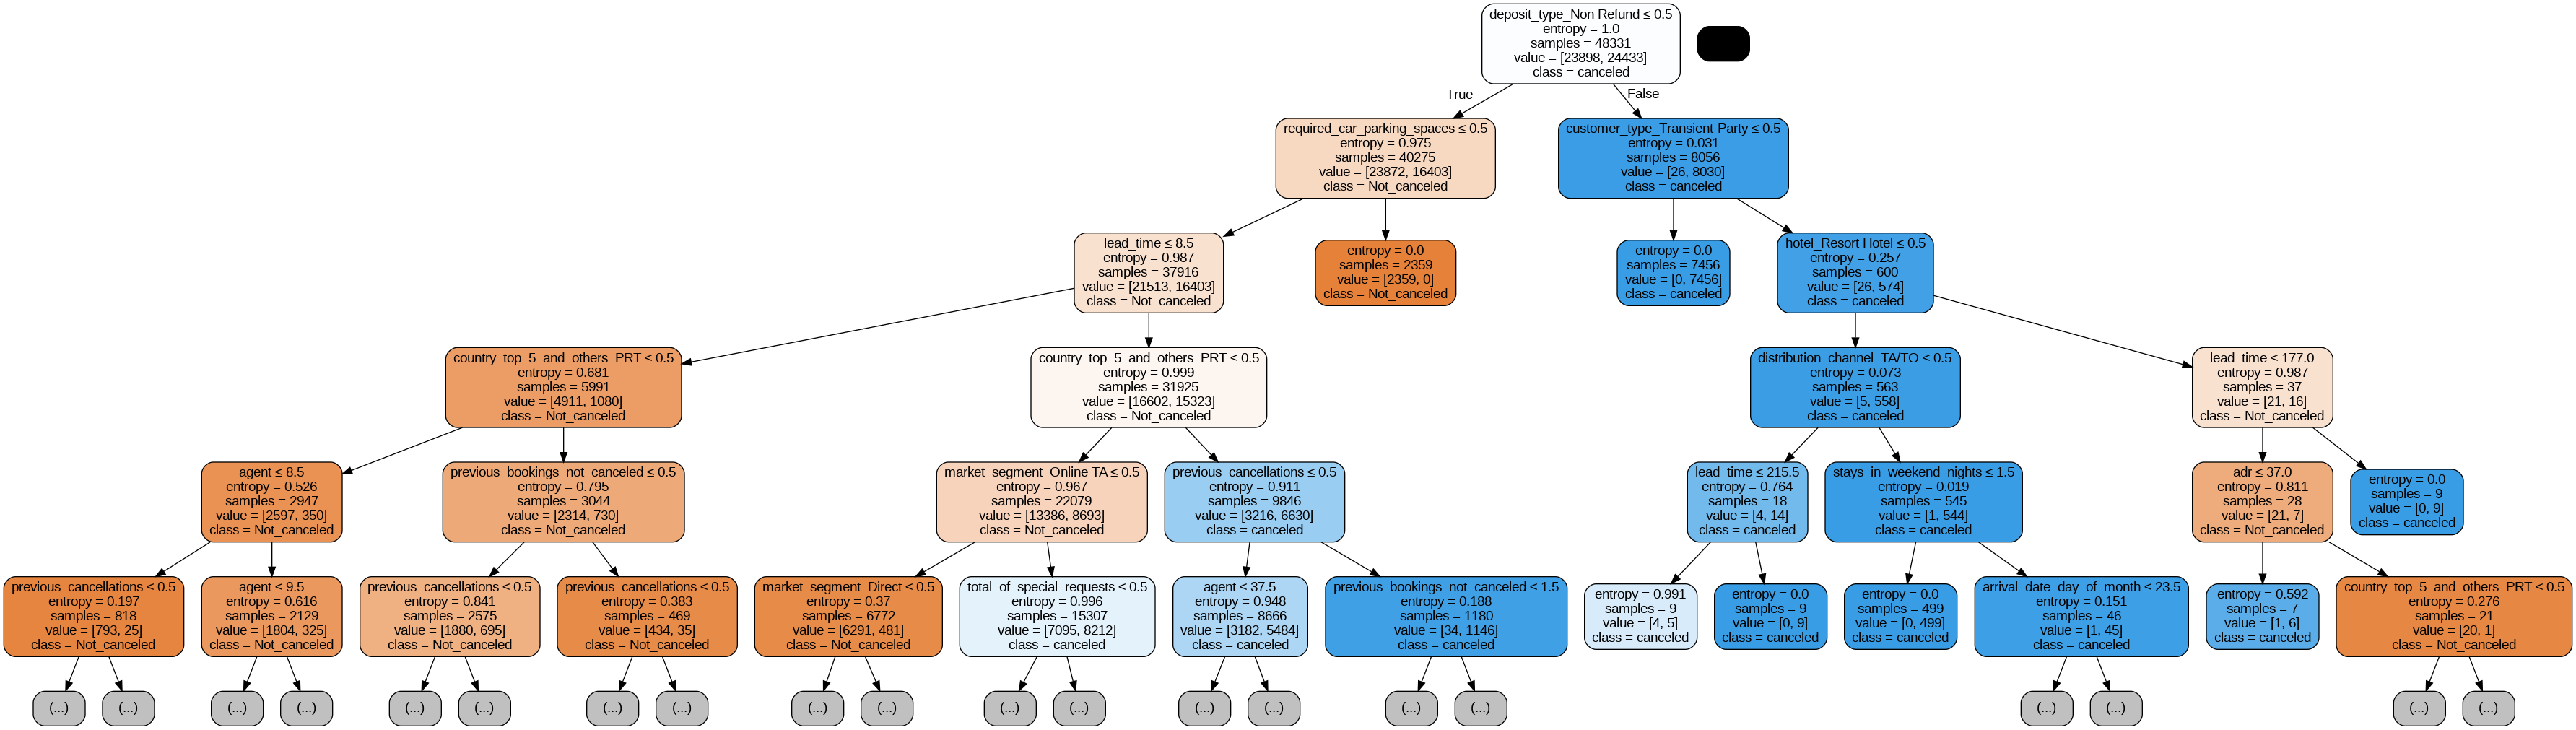

In [388]:
from six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(arbol, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True,
                feature_names=features,
                class_names=['Not_canceled','canceled'],
                max_depth=5)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

Analisis del arbol

*   El nodo raiz evalua segun la variable deposit_type_Non_Refound,donde vemos que la gente tiende a cancelar la reserva, si esta tiene reembolso
*   



In [389]:
# veo que se usa mucho agent para decidir, probar sin agent o hacer mas transformaciones

F1-Score: 0.8606505102040816


Text(0.5, 1.0, 'matriz de confusion del modelo optimizado')

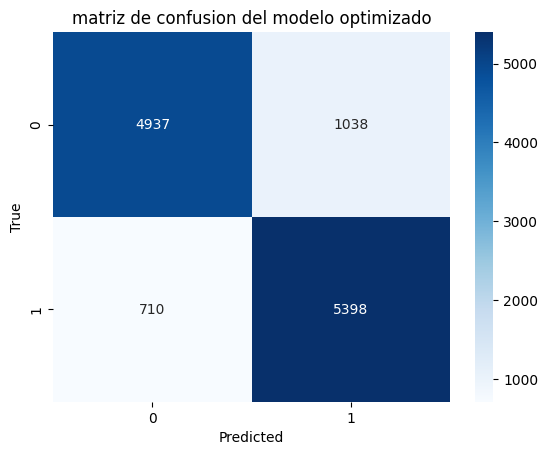

In [390]:
#Evalúo el Arbol con los mejores hiperparámetros
y_pred= arbol.predict(x_test)

print('F1-Score: {}'.format(f1_score(y_test, y_pred, average='binary')))
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("matriz de confusion del modelo optimizado")

El F1-score obtenido con los datos de testeo es consistente con el obtenido con los datos de entrenamiento, nos indica que el modelo generaliza bien y no está sobreajustado.

In [391]:
# porcentaje de seguridad al decidir si se va a cancelar una reserva
arbol.predict_proba(x_test)

array([[1.        , 0.        ],
       [1.        , 0.        ],
       [0.8961039 , 0.1038961 ],
       ...,
       [0.83333333, 0.16666667],
       [0.        , 1.        ],
       [0.        , 1.        ]])

In [396]:
# exportamos el mejor modelo
joblib.dump(model, 'modelo_optimizado.joblib')

['modelo_optimizado.joblib']

#Prediccion del modelo optimizado contra ds_test

In [393]:
#Realizamos una predicción sobre el set de test
y_pred_final = arbol.predict(dsHotelTestCopy)
#Valores Predichos
y_pred_final

array([1, 1, 1, ..., 1, 1, 0])

In [394]:
ds_submission = pd.DataFrame({'id': dsHotelTest['id'], 'is_canceled': y_pred_final})
ds_submission.head()

,id,is_canceled
0,e6d0d58a-ab96-44d3-b28f-85df1cc15f1e,1
1,aba9aac2-4495-4645-a60e-90328713c999,1
2,b345b5dc-c804-4d77-a39f-1f4e65d1f1ad,1
3,ce1b400e-afa1-4946-bdff-004b859eb61c,1
4,c4fbec0d-8e2e-4db2-9d4f-a6ccb9f51214,1


In [397]:
ds_submission.to_csv('./arbol_optimizado.csv', index=False)